In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
train_dir = '/content/drive/MyDrive/Training'
test_dir = '/content/drive/MyDrive/Testing'

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

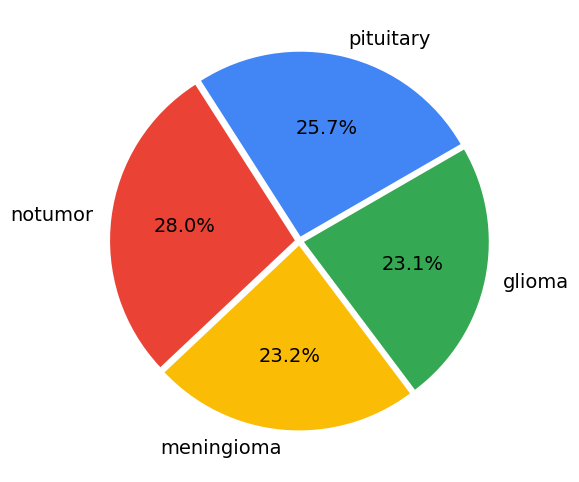

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

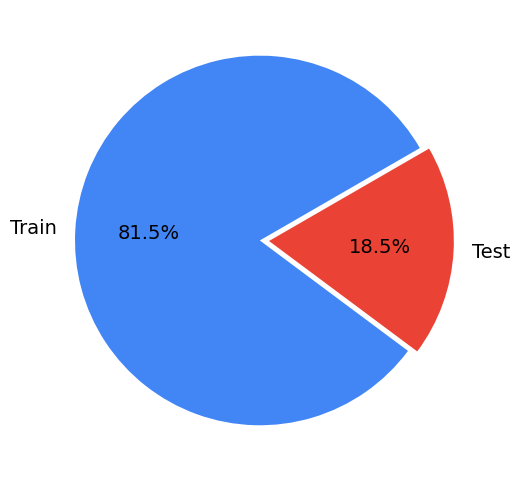

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

Original Image Shape: (512, 512, 3)
Grayscale Image Shape: (512, 512)


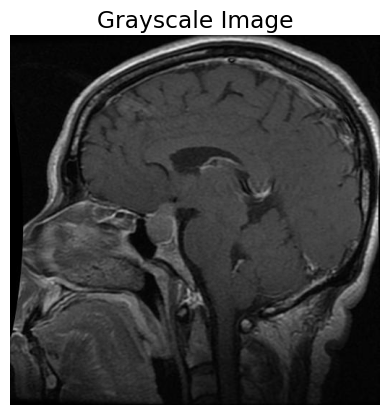

In [ ]:
def convert_to_grayscale(image_path):
    img = Image.open(image_path).convert('L')
    return np.array(img)

image_path = train_paths[0]
grayscale_image = convert_to_grayscale(image_path)

print(f"Original Image Shape: {np.array(Image.open(image_path)).shape}")
print(f"Grayscale Image Shape: {grayscale_image.shape}")

plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [ ]:
def denoise_image(image, sigma=1.0):
    return gaussian_filter(image, sigma=sigma)

image_path = train_paths[0]
grayscale_image = convert_to_grayscale(image_path)

denoised_image = denoise_image(grayscale_image, sigma=1.0)

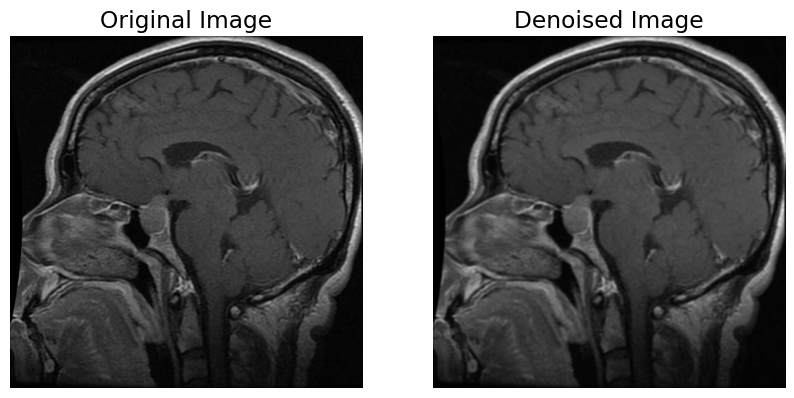

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

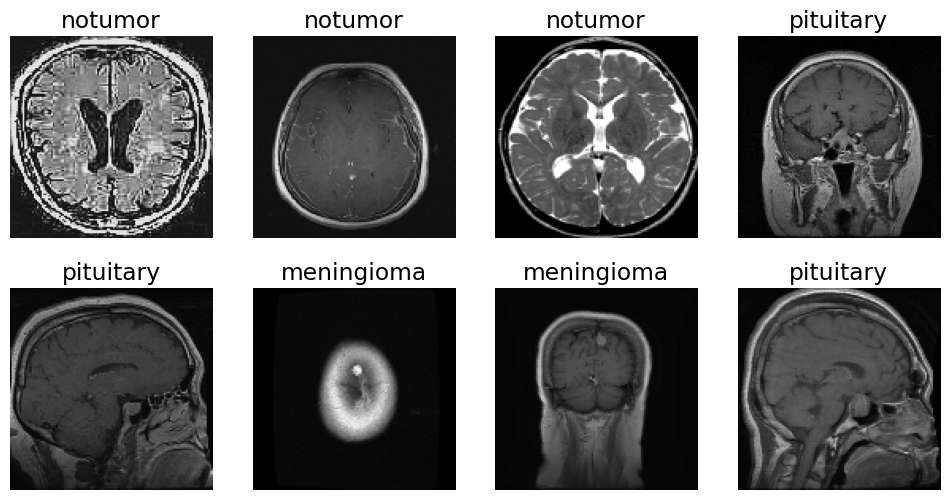

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

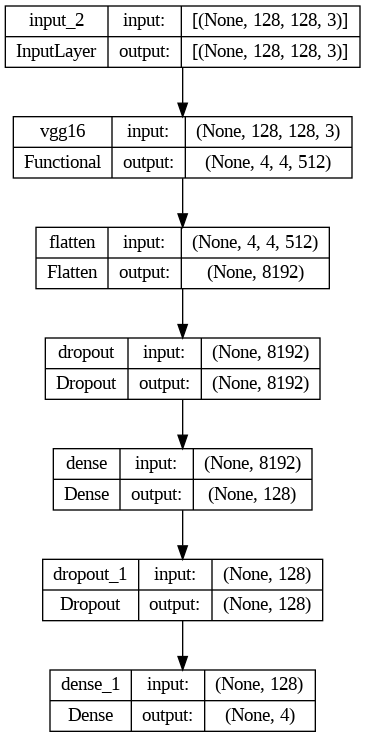

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

train_generator = datagen(train_paths, train_labels, batch_size=batch_size)

history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps)

Epoch 1/2
288/288 [==============================] - 3668s 13s/step - loss: 0.3873 - sparse_categorical_accuracy: 0.8503
Epoch 2/2
  1/288 [..............................] - ETA: 9:02 - loss: 0.0711 - sparse_categorical_accuracy: 1.0000

288/288 [==============================] - 2s 463us/step - loss: 0.0711 - sparse_categorical_accuracy: 1.0000


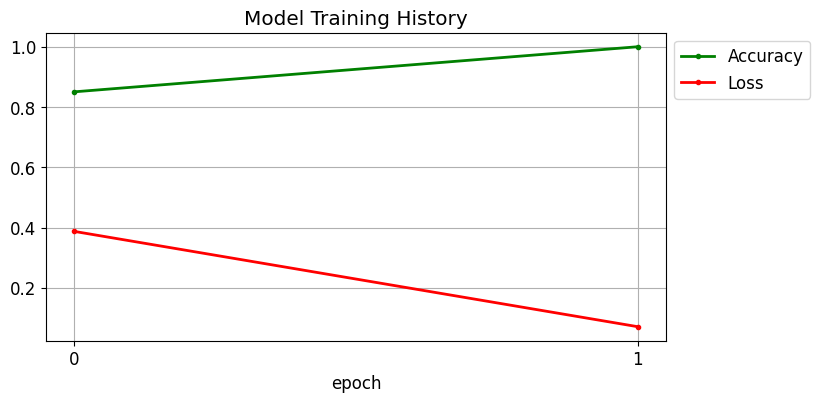

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


  2%|▎         | 1/40 [00:26<17:25, 26.80s/it]

1/1 [==============================] - 7s 7s/step


  5%|▌         | 2/40 [00:52<16:42, 26.39s/it]

1/1 [==============================] - 7s 7s/step


  8%|▊         | 3/40 [01:21<16:49, 27.29s/it]

1/1 [==============================] - 7s 7s/step


 10%|█         | 4/40 [01:48<16:26, 27.40s/it]

1/1 [==============================] - 6s 6s/step


 12%|█▎        | 5/40 [02:16<16:07, 27.64s/it]

1/1 [==============================] - 5s 5s/step


 15%|█▌        | 6/40 [02:42<15:21, 27.09s/it]

1/1 [==============================] - 5s 5s/step


 18%|█▊        | 7/40 [03:08<14:40, 26.68s/it]

1/1 [==============================] - 6s 6s/step


 20%|██        | 8/40 [03:34<14:03, 26.35s/it]

1/1 [==============================] - 6s 6s/step


 22%|██▎       | 9/40 [04:00<13:30, 26.14s/it]

1/1 [==============================] - 6s 6s/step


 25%|██▌       | 10/40 [04:26<13:06, 26.22s/it]

1/1 [==============================] - 7s 7s/step


 28%|██▊       | 11/40 [04:55<13:09, 27.21s/it]

1/1 [==============================] - 7s 7s/step


 30%|███       | 12/40 [05:23<12:45, 27.33s/it]

1/1 [==============================] - 7s 7s/step


 32%|███▎      | 13/40 [05:49<12:08, 26.98s/it]

1/1 [==============================] - 6s 6s/step


 35%|███▌      | 14/40 [06:16<11:37, 26.83s/it]

1/1 [==============================] - 5s 5s/step


 38%|███▊      | 15/40 [06:42<11:10, 26.80s/it]

1/1 [==============================] - 5s 5s/step


 40%|████      | 16/40 [07:09<10:42, 26.75s/it]

1/1 [==============================] - 5s 5s/step


 42%|████▎     | 17/40 [07:34<10:03, 26.22s/it]

1/1 [==============================] - 7s 7s/step


 45%|████▌     | 18/40 [08:01<09:44, 26.57s/it]

1/1 [==============================] - 7s 7s/step


 48%|████▊     | 19/40 [08:28<09:17, 26.57s/it]

1/1 [==============================] - 7s 7s/step


 50%|█████     | 20/40 [08:56<09:00, 27.04s/it]

1/1 [==============================] - 7s 7s/step


 52%|█████▎    | 21/40 [09:24<08:39, 27.33s/it]

1/1 [==============================] - 7s 7s/step


 55%|█████▌    | 22/40 [09:52<08:12, 27.37s/it]

1/1 [==============================] - 6s 6s/step


 57%|█████▊    | 23/40 [10:17<07:36, 26.87s/it]

1/1 [==============================] - 6s 6s/step


 60%|██████    | 24/40 [10:43<07:03, 26.46s/it]

1/1 [==============================] - 5s 5s/step


 62%|██████▎   | 25/40 [11:07<06:27, 25.83s/it]

1/1 [==============================] - 5s 5s/step


 65%|██████▌   | 26/40 [11:32<05:57, 25.56s/it]

1/1 [==============================] - 5s 5s/step


 68%|██████▊   | 27/40 [11:58<05:31, 25.53s/it]

1/1 [==============================] - 6s 6s/step


 70%|███████   | 28/40 [12:24<05:10, 25.88s/it]

1/1 [==============================] - 7s 7s/step


 72%|███████▎  | 29/40 [12:53<04:54, 26.78s/it]

1/1 [==============================] - 7s 7s/step


 75%|███████▌  | 30/40 [13:20<04:29, 26.92s/it]

1/1 [==============================] - 7s 7s/step


 78%|███████▊  | 31/40 [13:48<04:03, 27.05s/it]

1/1 [==============================] - 7s 7s/step


 80%|████████  | 32/40 [14:15<03:36, 27.09s/it]

1/1 [==============================] - 6s 6s/step


 82%|████████▎ | 33/40 [14:44<03:13, 27.71s/it]

1/1 [==============================] - 5s 5s/step


 85%|████████▌ | 34/40 [15:14<02:49, 28.32s/it]

1/1 [==============================] - 7s 7s/step


 88%|████████▊ | 35/40 [15:40<02:18, 27.78s/it]

1/1 [==============================] - 7s 7s/step


 90%|█████████ | 36/40 [16:09<01:51, 27.92s/it]

1/1 [==============================] - 7s 7s/step


 92%|█████████▎| 37/40 [16:35<01:22, 27.61s/it]

1/1 [==============================] - 7s 7s/step


 95%|█████████▌| 38/40 [17:04<00:55, 27.80s/it]

1/1 [==============================] - 6s 6s/step


 98%|█████████▊| 39/40 [17:30<00:27, 27.35s/it]

1/1 [==============================] - 5s 5s/step


100%|██████████| 40/40 [17:57<00:00, 27.15s/it]

1/1 [==============================] - 5s 5s/step


41it [18:22, 26.88s/it]


41/41 [==============================] - 261s 6s/step


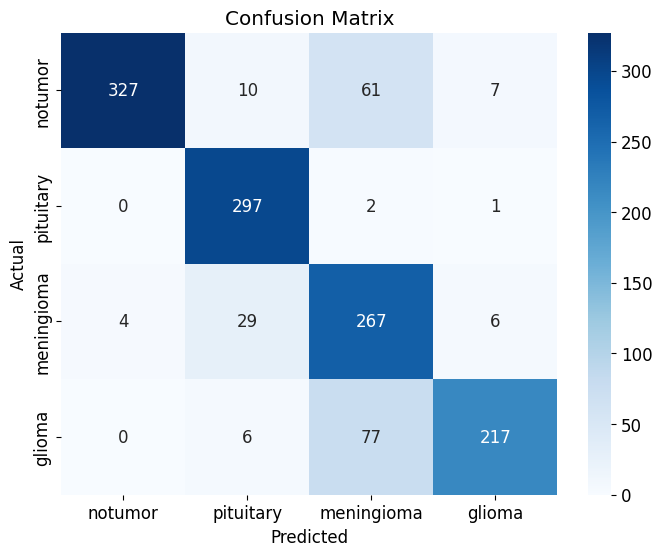

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

test_predictions = model.predict(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1))
test_predictions = np.argmax(test_predictions, axis=-1)

y_true = encode_label(test_labels)
y_pred = test_predictions

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       405
           1       0.87      0.99      0.93       300
           2       0.66      0.87      0.75       306
           3       0.94      0.72      0.82       300

    accuracy                           0.85      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.87      0.85      0.85      1311



1/1 [==============================] - 0s 184ms/step


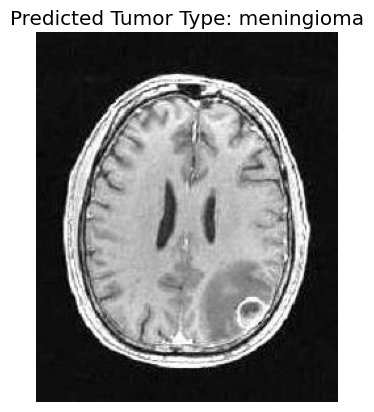

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_image_path = '/content/drive/MyDrive/Te-no_0150.jpg'

test_img = image.load_img(test_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
test_img_array = image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)
test_img_array = preprocess_input(test_img_array)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions[0])
predicted_label = decode_label([predicted_class])[0]

img = mpimg.imread(test_image_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.title("Predicted Tumor Type: " + predicted_label)
plt.show()